In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import chi2_contingency

In [2]:
data = pd.read_excel(r"Project data.xls")

In [3]:
data.head()

,business_registered,TIN,business_license,subsector,MSE_type,loan,land_premise,one_stop_service,util_rate,current_capital,initial_capital,gender,years_establish,years_schooling,no_paid_workers,highest_education
0,1,0,1,1,1,1,0,1,5,3000,2000.0,0,0,10,3,4
1,1,1,1,1,1,1,1,1,25,100000,500.0,1,10,10,3,4
2,1,1,1,1,1,0,0,1,30,15000,12000.0,0,1,10,3,4
3,1,1,1,1,1,1,0,1,40,50000,4500.0,0,3,10,3,4
4,1,1,1,1,1,1,0,1,50,15000,6000.0,0,4,9,3,4


In [4]:
# correcting categorical data type
categorical_columns = data.columns[~ data.columns.isin(["util_rate", "current_capital", "initial_capital", "years_establish",
                    "years_schooling", "no_paid_workers"])]
for col in categorical_columns:
    data[col] = pd.Categorical(data[col])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   business_registered  860 non-null    category
 1   TIN                  860 non-null    category
 2   business_license     860 non-null    category
 3   subsector            860 non-null    category
 4   MSE_type             860 non-null    category
 5   loan                 860 non-null    category
 6   land_premise         860 non-null    category
 7   one_stop_service     860 non-null    category
 8   util_rate            860 non-null    int64   
 9   current_capital      860 non-null    int64   
 10  initial_capital      860 non-null    float64 
 11  gender               860 non-null    category
 12  years_establish      860 non-null    int64   
 13  years_schooling      860 non-null    int64   
 14  no_paid_workers      860 non-null    int64   
 15  highest_education    86

# EDA

In [16]:
sns.set_theme(
    context="paper",
    style="ticks",
    palette="colorblind",
    font="sans-serif"
)

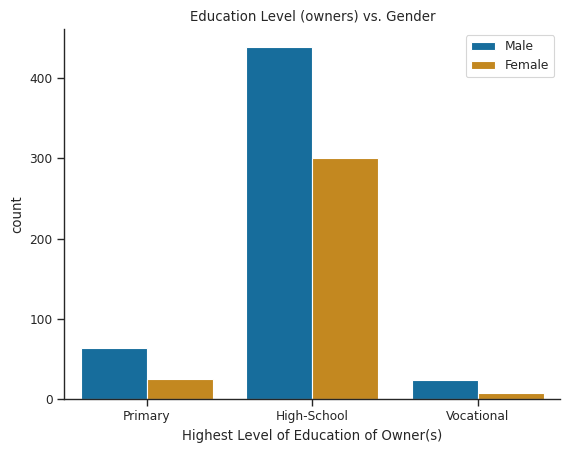

In [17]:
sns.countplot(
    data = data,
    x = "highest_education",
    hue = "gender"
)
plt.title("Education Level (owners) vs. Gender")
plt.xlabel("Highest Level of Education of Owner(s)")
plt.xticks(ticks =[0, 1, 2], labels=["Primary", "High-School", "Vocational"])
plt.legend(labels=["Male", "Female"])
sns.despine()
plt.show()

In [7]:
subsector_count = data["subsector"].value_counts().sort_index().reset_index()
subsector_count["label"] = subsector_count["subsector"].map({
    1 : "Metal and wood work",
    2 : "Construction",
    3 : "Agro-processing",
    4 : "Textile and garment",
    5 : "Leather and footwear",
    6 : "Retail",
    7 : "Urban agriculture",
    8 : "Others"
})
subsector_count

,subsector,count,label
0,1,122,Metal and wood work
1,2,64,Construction
2,3,183,Agro-processing
3,4,87,Textile and garment
4,5,34,Leather and footwear
5,6,273,Retail
6,7,42,Urban agriculture
7,8,55,Others


In [43]:
pie = px.pie(
    data_frame=subsector_count,
    names="label",
    values="count",
    title="Sub-Sectors of MSE",
    hole=0.4,
    template="plotly_white",
    color_discrete_sequence=px.colors.qualitative.Safe
)
pie.update_traces(textinfo='percent+label', hoverinfo='label+value+percent')
pie.update_layout(
    margin=dict(t=33, b=25, l=50, r=50)
)
pie

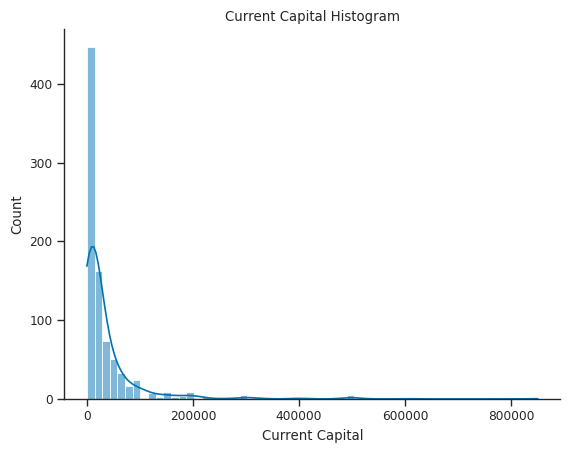

In [44]:
sns.histplot(
    data = data,
    x = "current_capital",
    kde = True
)
plt.title("Current Capital Histogram")
plt.xlabel("Current Capital")
sns.despine()
plt.show()

# current cpaital vs others

### recoding current capital

In [45]:
data["current_capital"].describe()

count       860.000000
mean      34234.709302
std       68692.331486
min         100.000000
25%        5000.000000
50%       12000.000000
75%       30000.000000
max      850000.000000
Name: current_capital, dtype: float64

In [52]:
mmin =  data.current_capital.min()
mmax = data.current_capital.max()
first_quartile = data.current_capital.quantile(0.25)
second_quartile = data.current_capital.quantile(0.5)
third_quartile = data.current_capital.quantile(0.75)
print(mmin, first_quartile, second_quartile, third_quartile, mmax)


100 5000.0 12000.0 30000.0 850000


In [63]:
# splitting current capital
data["current_capital_categorical"] = pd.cut(data["current_capital"], bins=[mmin-1, first_quartile, second_quartile, third_quartile, mmax+1], labels=["Low", "Low-medium", "High-medium", "High"])

In [67]:
cat_compare = data[["current_capital_categorical", "gender", "highest_education"]]
cat_compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   current_capital_categorical  860 non-null    category
 1   gender                       860 non-null    category
 2   highest_education            860 non-null    category
dtypes: category(3)
memory usage: 3.1 KB


### current capital vs gender

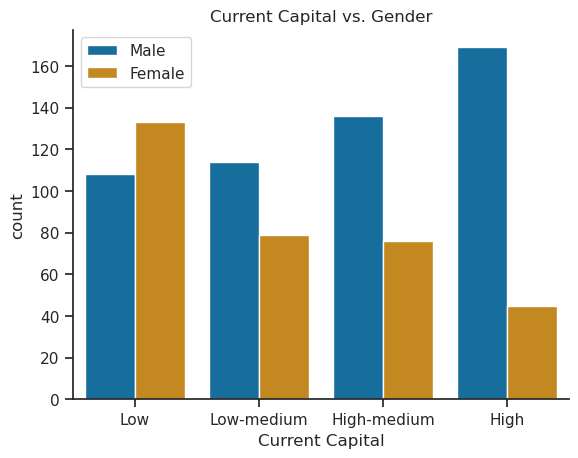

In [141]:
sns.countplot(
    data = cat_compare,
    x = "current_capital_categorical",
    hue = "gender"
)
plt.title("Current Capital vs. Gender")
plt.xlabel("Current Capital")
plt.legend(labels=["Male", "Female"])
sns.despine()
plt.show()

In [152]:
tab1 = pd.crosstab(cat_compare["current_capital_categorical"], data["gender"])

chi2, p, dof, expected1 = chi2_contingency(tab1)

print(f"Statistics: {chi2}\np-value: {p}\ndegree of freedom: {dof}\n\nobserved: \n{tab1}\n\nexpected: \n{expected1} ")

Statistics: 56.90504500890765
p-value: 2.6926638752357543e-12
degree of freedom: 3

observed: 
gender                         0    1
current_capital_categorical          
Low                          108  133
Low-medium                   114   79
High-medium                  136   76
High                         169   45

expected: 
[[147.68255814  93.31744186]
 [118.26860465  74.73139535]
 [129.91162791  82.08837209]
 [131.1372093   82.8627907 ]] 


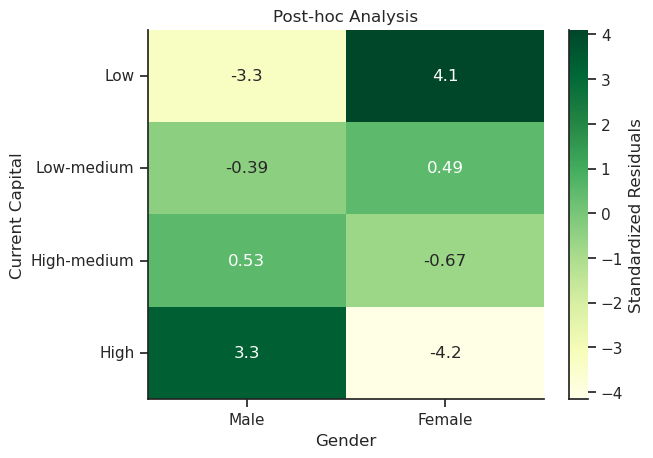

In [127]:
residuals = (tab1 - expected1)/ np.sqrt(expected1)
residuals.columns = ["Male", "Female"]

sns.heatmap(residuals, annot=True, center=0, cmap = "YlGn", cbar_kws={"label" : "Standardized Residuals"})
plt.title("Post-hoc Analysis")
plt.xlabel("Gender")
plt.ylabel("Current Capital")
sns.despine()
plt.show()

### current capital vs highest level of education (owners)

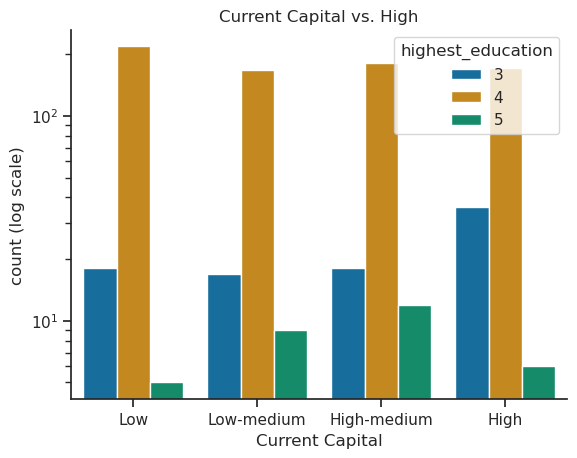

In [130]:
ax = sns.countplot(
    data = cat_compare,
    x = "current_capital_categorical",
    hue = "highest_education"
)
ax.set_yscale("log")
plt.title("Current Capital vs. High")
plt.ylabel("count (log scale)")
plt.xlabel("Current Capital")
sns.despine()
plt.show()

In [120]:
tab2 = pd.crosstab(cat_compare["current_capital_categorical"], cat_compare["highest_education"])
chi2, p, dof, expected2 = chi2_contingency(tab2)
print(f"Statistics: {chi2}\np-value: {p}\ndegree of freedom: {dof}\n\nobserved: \n{tab2}\n\nexpected: \n{expected2} ")

Statistics: 17.941791157357397
p-value: 0.006379320255157455
degree of freedom: 6

observed: 
highest_education             3    4   5
current_capital_categorical             
Low                          18  218   5
Low-medium                   17  167   9
High-medium                  18  182  12
High                         36  172   6

expected: 
[[ 24.94069767 207.09186047   8.96744186]
 [ 19.97325581 165.84534884   7.18139535]
 [ 21.93953488 182.17209302   7.88837209]
 [ 22.14651163 183.89069767   7.9627907 ]] 


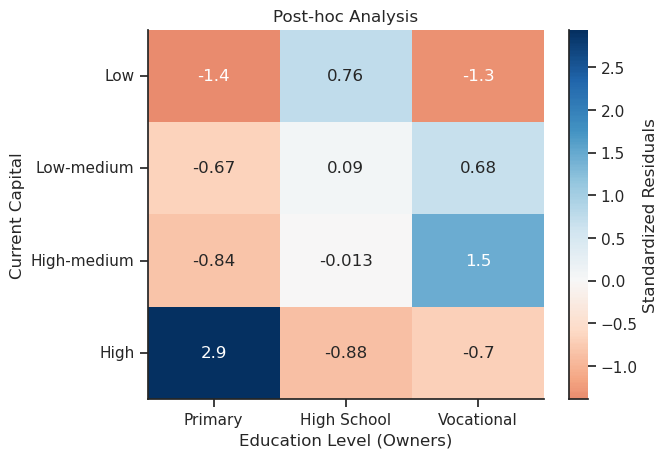

In [128]:
residuals = (tab2 - expected2)/ np.sqrt(expected2)
residuals.columns = ["Primary", "High School", "Vocational"]

sns.heatmap(residuals, annot=True, cmap="RdBu", center=0, cbar_kws = {"label" : "Standardized Residuals"})
plt.title("Post-hoc Analysis")
plt.xlabel("Education Level (Owners)")
plt.ylabel("Current Capital")
sns.despine()
plt.show()

# Multiple Linear Regression

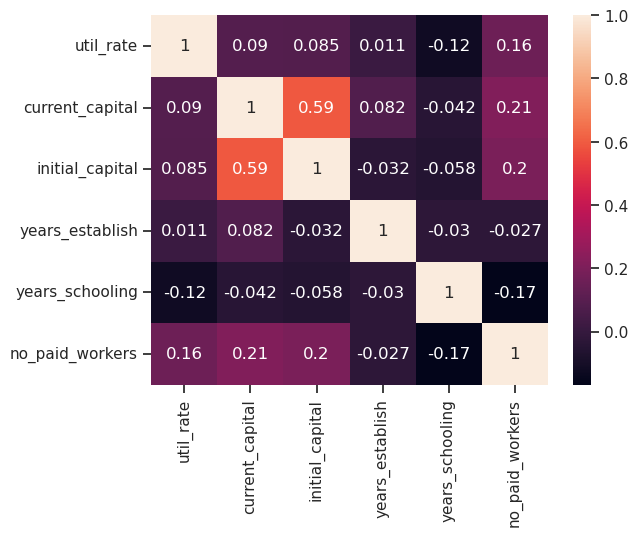

In [134]:
sns.heatmap(
    data.corr(numeric_only=True),
    annot=True
)
plt.show()